# Data Processing

In this notebook, we will prepare the dataset for modeling.  

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

**A. Data daily**

**1. Overview of Data after Data Understanding**

In [23]:
# Load the dataset
df_daily = pd.read_excel(r'../data/processed/data_daily_after_basic_understand.xlsx')

In [24]:
# Xác định loại dữ liệu
numerical_features = df_daily.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = df_daily.select_dtypes(include=['object']).columns.tolist()

print("Numeric features:", numerical_features)
print("Categorical features:", categorical_features)

Numeric features: ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipcover', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'moonphase']
Categorical features: ['conditions', 'description', 'icon', 'stations']


In [25]:
df_daily['datetime'] = pd.to_datetime(df_daily['datetime'])
df_daily = df_daily.sort_values('datetime').reset_index(drop=True)

**2. Drop missing columns**


In [26]:
# Kiểm tra missing values và duplicates
print("Số lượng giá trị thiếu:\n", df_daily.isnull().sum())
print("\nTỷ lệ thiếu (%):\n", (df_daily.isnull().mean() * 100).round(2))

dupes_daily = df_daily.duplicated().sum()
print(f"\nSố dòng trùng lặp: {dupes_daily}")

Số lượng giá trị thiếu:
 datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipcover            0
windgust               0
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk          2566
sunrise                0
sunset                 0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
dtype: int64

Tỷ lệ thiếu (%):
 datetime             0.00
tempmax              0.00
tempmin              0.00
temp                 0.00
feelslikemax         0.00
feelslikemin         0.00
feelslike            0.00
dew                  0.00
humidity             0.00
precip   

During the data exploration process, I observed that **only the `severerisk` column contains missing values**, with a **missing rate as high as 65.34%**. Such a high proportion of missing data suggests that the column provides limited informational value and may negatively impact model performance if retained. Furthermore, correlation analysis shows that `severerisk` has little to no relationship with the target variable. Keeping it would add noise rather than value to the model.  

Given the high missing rate, weak correlation, and lack of statistical reliability,  
the `severerisk` column will be **dropped** from the dataset prior to feature engineering and model training.

In [27]:
# Loại bỏ cột severisk
df_daily = df_daily.drop(columns=['severerisk'])
# Kiểm tra lại kết quả
print("Kích thước dữ liệu sau khi drop cột 'severerisk':", df_daily.shape)

Kích thước dữ liệu sau khi drop cột 'severerisk': (3927, 27)


**3. Train-test split**

In [28]:
# Chia train-test split theo thời gian, trong đó khoảng cách tập train và test là 7 ngày để tránh data leakage do tính chất thời gian của dữ liệu, temp là biến mục tiêu
train_size = int(len(df_daily) * 0.8)
# Tập huấn luyện kết thúc trước 7 ngày so với tập kiểm tra
train_data = df_daily.iloc[:train_size - 7] 
# Tập kiểm tra bắt đầu từ ngày thứ 7 sau tập huấn luyện đến hết
test_data = df_daily.iloc[train_size:]
print(f"Kích thước tập huấn luyện: {train_data.shape}")
print(f"Kích thước tập kiểm tra: {test_data.shape}")
print(f"Khoảng thời gian tập huấn luyện: {train_data['datetime'].min()} đến {train_data['datetime'].max()}")
print(f"Khoảng thời gian tập kiểm tra: {test_data['datetime'].min()} đến {test_data['datetime'].max()}")

# temp là biến mục tiêu
feature_cols = df_daily.columns.drop(['temp', 'datetime'])  # Loại bỏ cột temp khỏi features
X_train = train_data[feature_cols]
y_train = train_data['temp']
X_test = test_data[feature_cols]
y_test = test_data['temp']

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Kích thước tập huấn luyện: (3134, 27)
Kích thước tập kiểm tra: (786, 27)
Khoảng thời gian tập huấn luyện: 2015-01-01 00:00:00 đến 2023-07-31 00:00:00
Khoảng thời gian tập kiểm tra: 2023-08-08 00:00:00 đến 2025-10-01 00:00:00
X_train shape: (3134, 25), y_train shape: (3134,)
X_test shape: (786, 25), y_test shape: (786,)


**4. Observing and handling outliers**

In [29]:
# # Phát hiện outliers bằng phương pháp IQR
numeric_cols_d = df_daily.select_dtypes(include=[np.number]).columns

Q1_d = df_daily[numeric_cols_d].quantile(0.25)
Q3_d = df_daily[numeric_cols_d].quantile(0.75)
IQR_d = Q3_d - Q1_d

outliers_d = ((df_daily[numeric_cols_d] < (Q1_d - 1.5 * IQR_d)) | 
              (df_daily[numeric_cols_d] > (Q3_d + 1.5 * IQR_d))).sum()

print("Số lượng outliers (theo từng cột):\n", outliers_d)

Số lượng outliers (theo từng cột):
 tempmax               3
tempmin               1
temp                  2
feelslikemax          0
feelslikemin         20
feelslike             0
dew                  41
humidity             91
precip              639
precipcover         169
windgust            117
windspeed            59
winddir             664
sealevelpressure      1
cloudcover            0
visibility          119
solarradiation        0
solarenergy           0
uvindex               0
moonphase             0
dtype: int64


In [30]:
# Phân loại các cột dựa trên số lượng outliers
def classify_columns_by_outliers(X, outlier_threshold=0.05):
    """
    Phân loại cột numeric thành high outliers và low outliers
    outlier_threshold: tỷ lệ outliers để phân loại (mặc định 5%)
    """
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    Q1 = X[numeric_cols].quantile(0.25)
    Q3 = X[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    
    outlier_counts = ((X[numeric_cols] < (Q1 - 1.5 * IQR)) | 
                      (X[numeric_cols] > (Q3 + 1.5 * IQR))).sum()
    outlier_ratios = outlier_counts / len(X)
    
    high_outlier_cols = outlier_ratios[outlier_ratios > outlier_threshold].index.tolist()
    low_outlier_cols = outlier_ratios[outlier_ratios <= outlier_threshold].index.tolist()
    
    return high_outlier_cols, low_outlier_cols, outlier_ratios

# Phân loại cột cho dữ liệu daily
high_outlier_cols, low_outlier_cols, outlier_ratios = classify_columns_by_outliers(X_train, outlier_threshold=0.05)

print("=== Phân loại cột dựa trên outliers ===")
print(f"\nCột có nhiều outliers (>5%): {high_outlier_cols}")
print(f"\nCột có ít outliers (<=5%): {low_outlier_cols}")
print(f"\nTỷ lệ outliers chi tiết:\n{outlier_ratios.sort_values(ascending=False)}")

# Xác định cột categorical
nominal_cols = X_train.select_dtypes(include=['object']).columns.tolist()
ordinal_cols = []  # Nếu có cột ordinal, khai báo ở đây

print(f"\nCột nominal: {nominal_cols}")
print(f"Cột ordinal: {ordinal_cols}")

=== Phân loại cột dựa trên outliers ===

Cột có nhiều outliers (>5%): ['precip', 'winddir']

Cột có ít outliers (<=5%): ['tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precipcover', 'windgust', 'windspeed', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'moonphase']

Tỷ lệ outliers chi tiết:
winddir             0.166879
precip              0.166879
precipcover         0.037652
windgust            0.029036
visibility          0.027760
humidity            0.020740
windspeed           0.012763
cloudcover          0.010530
dew                 0.009572
feelslikemin        0.006063
sealevelpressure    0.000638
tempmax             0.000638
tempmin             0.000319
feelslike           0.000000
feelslikemax        0.000000
solarradiation      0.000000
solarenergy         0.000000
uvindex             0.000000
moonphase           0.000000
dtype: float64

Cột nominal: ['conditions', 'description', 'icon', 'sta

In [31]:
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder

# Tách các cột datetime
datetime_cols = X_train.select_dtypes(include=['datetime']).columns.tolist()

# Tách các cột không phải datetime (numeric và categorical)
train_non_datetime = train_data.drop(columns=datetime_cols)
test_non_datetime = test_data.drop(columns=datetime_cols)

# Tạo ColumnTransformer
transformers = []

# 1. RobustScaler cho numeric có nhiều outliers
if high_outlier_cols:
    transformers.append(('robust', RobustScaler(), high_outlier_cols))

# 2. StandardScaler cho numeric có ít outliers
if low_outlier_cols:
    transformers.append(('standard', StandardScaler(), low_outlier_cols))

# 3. OneHotEncoder cho nominal
if nominal_cols:
    transformers.append(('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_cols))

# 4. OrdinalEncoder cho ordinal (nếu có)
if ordinal_cols:
    transformers.append(('ordinal', OrdinalEncoder(), ordinal_cols))

# Tạo ColumnTransformer (passthrough để giữ nguyên các cột không được transform)
preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough', verbose_feature_names_out=False  # Giữ nguyên các cột không được transform
)

# ===== FIT VÀ TRANSFORM =====
print("\n=== Bắt đầu fit và transform dữ liệu ===")
train_transformed = preprocessor.fit_transform(train_non_datetime)

# Transform tập TEST (dùng parameters đã học từ train)
test_transformed = preprocessor.transform(test_non_datetime)

print(f"\nKích thước sau khi transform:")
print(f"  X_train: {train_non_datetime.shape} -> {train_transformed.shape}")
print(f"  X_test: {test_non_datetime.shape} -> {test_transformed.shape}")

# Kết hợp lại các cột datetime vào kết quả cuối cùng
# Đảm bảo rằng các cột datetime sẽ không bị thay đổi
train_transformed = pd.DataFrame(train_transformed)
test_transformed = pd.DataFrame(test_transformed)

# Thêm lại cột datetime vào kết quả cuối cùng
train_transformed[datetime_cols] = train_data[datetime_cols].reset_index(drop=True)
test_transformed[datetime_cols] = test_data[datetime_cols].reset_index(drop=True)

# Hiển thị kết quả
print(f"\nKích thước sau khi thêm cột datetime vào:")
print(f"  X_train: {train_transformed.shape}")
print(f"  X_test: {test_transformed.shape}")


=== Bắt đầu fit và transform dữ liệu ===

Kích thước sau khi transform:
  X_train: (3134, 25) -> (3134, 78)
  X_test: (786, 25) -> (786, 78)

Kích thước sau khi thêm cột datetime vào:
  X_train: (3134, 80)
  X_test: (786, 80)


In [32]:
# ...existing code...
# ===== Sửa lỗi: fit/transform + giữ tên cột + giữ datetime =====
import os
from pandas.api import types as pd_types

# Fit trên dữ liệu không chứa datetime (nếu chưa fit)
preprocessor.fit(train_non_datetime)

train_arr = preprocessor.transform(train_non_datetime)
test_arr = preprocessor.transform(test_non_datetime)

# Tạo tên feature an toàn
try:
    # sklearn >=1.0
    feature_names = list(preprocessor.get_feature_names_out(train_non_datetime.columns))
except Exception:
    feature_names = []
    used_cols = []
    for name, trans, cols in preprocessor.transformers_:
        if name == 'remainder':
            continue
        cols_list = list(cols) if isinstance(cols, (list, tuple, np.ndarray)) else [cols]
        used_cols.extend(cols_list)
        fitted = preprocessor.named_transformers_.get(name, None)
        if fitted is not None and hasattr(fitted, "get_feature_names_out"):
            try:
                out = fitted.get_feature_names_out(cols_list)
                feature_names.extend(list(out))
            except Exception:
                feature_names.extend([f"{name}__{c}" for c in cols_list])
        else:
            feature_names.extend([f"{name}__{c}" for c in cols_list])
    # thêm passthrough nếu có
    if getattr(preprocessor, "remainder", None) == 'passthrough':
        passthrough = [c for c in train_non_datetime.columns if c not in used_cols]
        feature_names.extend(passthrough)

# Fallback nếu mismatch kích thước
if len(feature_names) != train_arr.shape[1]:
    feature_names = [f"feat_{i}" for i in range(train_arr.shape[1])]

# Chuyển về DataFrame và giữ index gốc
train_transformed = pd.DataFrame(train_arr, columns=feature_names, index=train_non_datetime.index)
test_transformed = pd.DataFrame(test_arr, columns=feature_names, index=test_non_datetime.index)

# Lấy cột datetime từ train_data/test_data (giữ dtype)
datetime_cols = [c for c in train_data.columns if pd_types.is_datetime64_any_dtype(train_data[c])]

for dt in datetime_cols:
    # nếu tên datetime vô tình có trong feature_names thì ghi đè bằng giá trị gốc
    train_transformed[dt] = train_data.loc[train_transformed.index, dt].values
    test_transformed[dt] = test_data.loc[test_transformed.index, dt].values

# Đảm bảo thứ tự cột: feature_names (không chứa datetime) + datetime_cols
final_feature_names = [c for c in feature_names if c not in datetime_cols] + datetime_cols
train_transformed = train_transformed[final_feature_names]
test_transformed = test_transformed[final_feature_names]

# Thêm target 'temp' lại vào nếu cần và lưu
train_data_transformed = train_transformed.copy()
train_data_transformed['temp'] = train_data.loc[train_transformed.index, 'temp'].values
test_data_transformed = test_transformed.copy()
test_data_transformed['temp'] = test_data.loc[test_transformed.index, 'temp'].values

save_dir = '../data/processed/'
os.makedirs(save_dir, exist_ok=True)
train_data_transformed.to_excel(save_dir + 'train_data.xlsx', index=False)
test_data_transformed.to_excel(save_dir + 'test_data.xlsx', index=False)
X_train_transformed = train_transformed.copy()
X_test_transformed = test_transformed.copy()
X_train_transformed.to_excel(save_dir + 'X_train.xlsx', index=False)
X_test_transformed.to_excel(save_dir + 'X_test.xlsx', index=False)
# ...existing code...

In [33]:
# Save the processed data (train_data_transformed / test_data_transformed already created above)
import os
save_dir = '../data/processed/'
os.makedirs(save_dir, exist_ok=True)

# Save raw copies if needed
train_data.to_excel(save_dir + 'train_data_raw.xlsx', index=False)
test_data.to_excel(save_dir + 'test_data_raw.xlsx', index=False)

# Helper to convert transformed array -> DataFrame with sensible column names
def to_df(arr, index, fallback_prefix='feature'):
    if isinstance(arr, np.ndarray):
        if 'feature_names_out' in globals() and len(feature_names_out) == arr.shape[1]:
            cols = feature_names_out
        else:
            cols = [f'{fallback_prefix}_{i}' for i in range(arr.shape[1])]
        return pd.DataFrame(arr, columns=cols, index=index)
    elif isinstance(arr, pd.DataFrame):
        return arr.copy()
    else:
        raise TypeError("Transformed data must be numpy.ndarray or pandas.DataFrame")

# Convert and save train_data_transformed / test_data_transformed (no X/y combine)
train_data.to_excel(save_dir + 'train_data.xlsx', index=False)
test_data.to_excel(save_dir + 'test_data.xlsx', index=False)

train_index = X_train.index if isinstance(X_train, pd.DataFrame) else range(X_train.shape[0])
test_index  = X_test.index  if isinstance(X_test, pd.DataFrame)  else range(X_test.shape[0])

# Chuyển X_train_transformed / X_test_transformed -> DataFrame
if 'X_train_transformed' in globals():
    train_data_transformed_df = to_df(X_train_transformed, index=train_index, fallback_prefix='Xtrain_feat')
    train_data_transformed_df.to_excel(save_dir + 'train_data_transformed.xlsx', index=False)

if 'X_test_transformed' in globals():
    test_data_transformed_df = to_df(X_test_transformed, index=test_index, fallback_prefix='Xtest_feat')
    test_data_transformed_df.to_excel(save_dir + 'test_data_transformed.xlsx', index=False)

train_data_transformed_df.to_excel(save_dir + 'train_data.xlsx', index=False)
test_data_transformed_df.to_excel(save_dir + 'test_data.xlsx', index=False)

# Chuyển y_train / y_test thành Series nếu đang là ndarray
y_train_series = pd.Series(y_train) if isinstance(y_train, np.ndarray) else y_train.squeeze()
y_test_series  = pd.Series(y_test)  if isinstance(y_test, np.ndarray)  else y_test.squeeze()

# Đặt tên cột nếu chưa có
if y_train_series.name is None:
    y_train_series.name = 'target'
if y_test_series.name is None:
    y_test_series.name = 'target'

# Lưu ra Excel
y_train_series.to_frame().to_excel(save_dir + 'y_train.xlsx', index=False)
y_test_series.to_frame().to_excel(save_dir + 'y_test.xlsx', index=False)


In [34]:
feature_cols = train_transformed.columns.drop(['temp', 'datetime']) 
X_train_transformed = train_transformed[feature_cols]
y_train_transformed = train_transformed['temp']
X_test_transformed = test_transformed[feature_cols]
y_test_transformed = test_transformed['temp']

**TRAIN MODEL**

In [35]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

target = train_data_transformed['temp'].values

n_past = 7
n_future = 5

X, y = [], []
for i in range(len(target) - n_past - n_future + 1):
    X.append(target[i:i+n_past])
    y.append(target[i+n_past:i+n_past+n_future])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

split_idx = int(len(X) * 0.8)
X_train_seq, X_test_seq = X[:split_idx], X[split_idx:]
y_train_seq, y_test_seq = y[:split_idx], y[split_idx:]

base_model = RandomForestRegressor(n_estimators=200, random_state=42)
multi_model = MultiOutputRegressor(base_model)

multi_model.fit(X_train_seq, y_train_seq)

y_pred_seq = multi_model.predict(X_test_seq)

mse = mean_squared_error(y_test_seq, y_pred_seq, multioutput='raw_values')
mae = mean_absolute_error(y_test_seq, y_pred_seq, multioutput='raw_values')

for i in range(n_future):
    print(f"Ngày {i+1}: MSE={mse[i]:.4f}, MAE={mae[i]:.4f}")

print(f"Trung bình MSE: {np.mean(mse):.4f}")
print(f"Trung bình MAE: {np.mean(mae):.4f}")


X shape: (3123, 7)
y shape: (3123, 5)
Ngày 1: MSE=2.9767, MAE=1.2704
Ngày 2: MSE=6.2263, MAE=1.9013
Ngày 3: MSE=7.5937, MAE=2.1234
Ngày 4: MSE=8.4063, MAE=2.2642
Ngày 5: MSE=9.1083, MAE=2.3556
Trung bình MSE: 6.8623
Trung bình MAE: 1.9830


**RIDGE REGRESSION**

X_train shape: (3134, 19)
X_test shape : (786, 19)
Test RMSE: 0.190
Test R^2 : 0.999
       datetime  temp_true  temp_pred
3141 2023-08-08       29.1  29.392577
3142 2023-08-09       30.4  30.557099
3143 2023-08-10       29.0  29.313148
3144 2023-08-11       27.7  27.927119
3145 2023-08-12       28.3  28.400968
3146 2023-08-13       29.8  30.033079
3147 2023-08-14       29.3  29.061528
3148 2023-08-15       28.4  28.483324
3149 2023-08-16       29.4  29.610899
3150 2023-08-17       31.7  31.817772


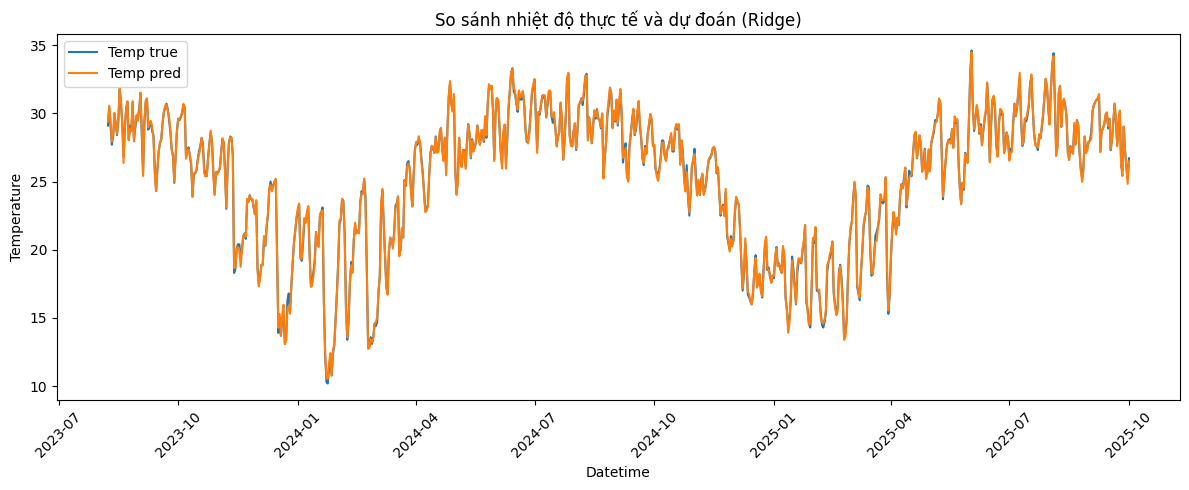

In [40]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Lấy tất cả cột numeric làm feature, TRỪ 'temp' (vì đó là label)
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
if "temp" in numeric_cols:
    numeric_cols.remove("temp")

# Drop các hàng bị NaN trong feature + label (do lag/rolling những ngày đầu)
train_data_model = train_data.dropna(subset=numeric_cols + ["temp"])
test_data_model  = test_data.dropna(subset=numeric_cols + ["temp"])

X_train = train_data_model[numeric_cols]
y_train = train_data_model["temp"].values
X_test = test_data_model[numeric_cols]
y_test = test_data_model["temp"].values

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)

# Fit Ridge Regression
model = Ridge(alpha=1.0)  # có thể chỉnh alpha sau
model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Đánh giá nhanh
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test R^2 : {r2:.3f}")

# Ghép lại để xem cặp (datetime, temp thật, temp dự đoán)
results = test_data_model[["datetime", "temp"]].copy()
results.rename(columns={"temp": "temp_true"}, inplace=True)
results["temp_pred"] = y_pred

print(results.head(10))

# Đảm bảo cột datetime đúng kiểu
results_plot = results.copy()
results_plot["datetime"] = pd.to_datetime(results_plot["datetime"])

# Sắp xếp theo thời gian cho chắc
results_plot = results_plot.sort_values("datetime")

plt.figure(figsize=(12, 5))

# Vẽ temp thật và temp dự đoán
plt.plot(results_plot["datetime"], results_plot["temp_true"], label="Temp true")
plt.plot(results_plot["datetime"], results_plot["temp_pred"], label="Temp pred")

plt.xlabel("Datetime")
plt.ylabel("Temperature")
plt.title("So sánh nhiệt độ thực tế và dự đoán (Ridge)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**RANDOM FOREST**

X_train: (3134, 19) X_test: (786, 19)
Random Forest RMSE: 0.021
Random Forest R^2 : 0.999


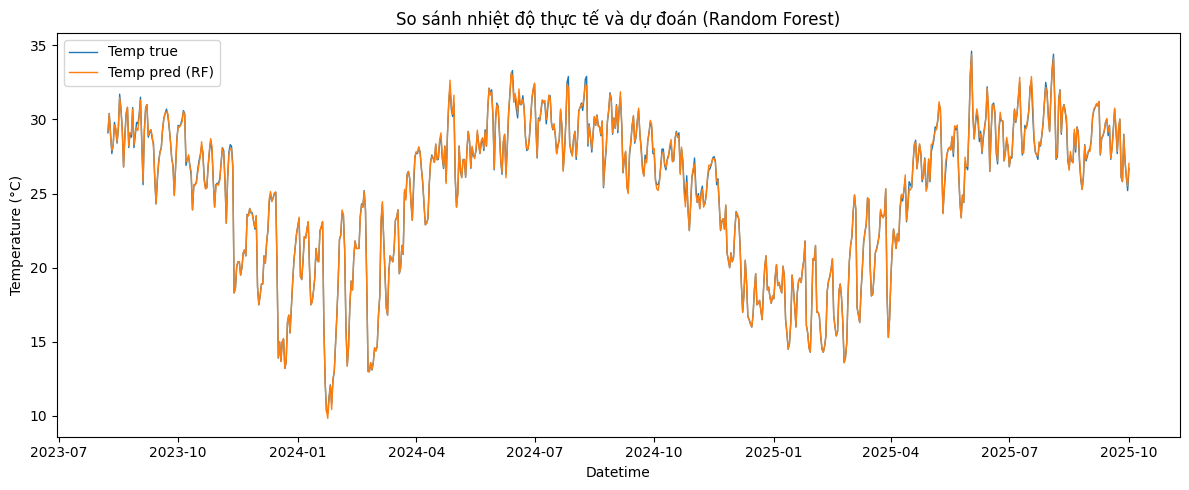

In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Chọn feature numeric
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
if "temp" in numeric_cols:
    numeric_cols.remove("temp")

# Loại NaN (do lag/rolling)
train_data_model = train_data.dropna(subset=numeric_cols + ["temp"])
test_data_model  = test_data.dropna(subset=numeric_cols + ["temp"])

X_train = train_data_model[numeric_cols]
y_train = train_data_model["temp"].values
X_test = test_data_model[numeric_cols]
y_test = test_data_model["temp"].values

print("X_train:", X_train.shape, "X_test:", X_test.shape)

# Train Random Forest
rf = RandomForestRegressor(
    n_estimators=400,      # số cây
    max_depth=None,        # để None cho cây tự mở rộng
    min_samples_split=5,   # tránh overfit nhẹ
    random_state=42,
    n_jobs=-1              # dùng hết CPU cores
)
rf.fit(X_train, y_train)

# Dự đoán
y_pred = rf.predict(X_test)

# Đánh giá
rmse = mean_squared_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"Random Forest RMSE: {rmse:.3f}")
print(f"Random Forest R^2 : {r2:.3f}")

# Plot so sánh
results = test_data_model[["datetime", "temp"]].copy()
results.rename(columns={"temp": "temp_true"}, inplace=True)
results["temp_pred"] = y_pred

results["datetime"] = pd.to_datetime(results["datetime"])
results = results.sort_values("datetime")

plt.figure(figsize=(12,5))
plt.plot(results["datetime"], results["temp_true"], label="Temp true", linewidth=1)
plt.plot(results["datetime"], results["temp_pred"], label="Temp pred (RF)", linewidth=1)
plt.xlabel("Datetime")
plt.ylabel("Temperature (°C)")
plt.title("So sánh nhiệt độ thực tế và dự đoán (Random Forest)")
plt.legend()
plt.tight_layout()
plt.show()

**LIGHTGBM**

In [45]:
import re
import numpy as np
import pandas as pd
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Chuẩn bị feature numeric và loại bỏ NaN 
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
if "temp" in numeric_cols:
    numeric_cols.remove("temp")

# Drop các hàng bị NaN do lag/rolling
train_data_model = train_data.dropna(subset=numeric_cols + ["temp"])
test_data_model  = test_data.dropna(subset=numeric_cols + ["temp"])

# X/y copies
X_train = train_data_model[numeric_cols].copy()
X_test  = test_data_model[numeric_cols].copy()
y_train = train_data_model["temp"].values
y_test  = test_data_model["temp"].values

# Chuẩn hóa tên cột cho LightGBM 
def _sanitize(name):
    return re.sub(r'[^0-9A-Za-z_]', '_', str(name))

sanitized_cols = [_sanitize(c) for c in X_train.columns.tolist()]
col_map = dict(zip(X_train.columns.tolist(), sanitized_cols))
X_train.columns = sanitized_cols
X_test.columns  = sanitized_cols

# Khởi tạo và fit LGBM 
model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]
)

# Dự đoán và đánh giá
y_pred = model.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print(f"LightGBM Test RMSE: {rmse:.3f}")
print(f"LightGBM Test R^2 : {r2:.3f}")

# Ghép datetime + temp thật + temp dự đoán
results = test_data_model[["datetime", "temp"]].copy()
results.rename(columns={"temp": "temp_thuc"}, inplace=True)
results["temp_du_doan"] = y_pred

print(results.head(10))

y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred)

print(f"LightGBM Test RMSE: {rmse:.3f}")
print(f"LightGBM Test R^2 : {r2:.3f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3368
[LightGBM] [Info] Number of data points in the train set: 3134, number of used features: 19
[LightGBM] [Info] Start training from score 24.811072
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 0.402922	valid_0's l2: 0.162346
[100]	valid_0's rmse: 0.131715	valid_0's l2: 0.0173488
[150]	valid_0's rmse: 0.132229	valid_0's l2: 0.0174845
Early stopping, best iteration is:
[114]	valid_0's rmse: 0.130413	valid_0's l2: 0.0170077
LightGBM Test RMSE: 0.130
LightGBM Test R^2 : 0.999
       datetime  temp_thuc  temp_du_doan
3141 2023-08-08       29.1     29.142655
3142 2023-08-09       30.4     30.430492
3143 2023-08-10       29.0     28.772601
3144 2023-08-11       27.7     27.818456
3145 2023-08-12       28.3     28.189700
3146 2023-08-13       29.8     29.735943
3147 

**MLPREGRESSOR**

In [49]:
# ...existing code...
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# Kiểm tra dữ liệu chuẩn bị sẵn
if 'X_train' not in globals() or 'X_test' not in globals():
    raise RuntimeError("X_train / X_test chưa tồn tại. Chạy cell chuẩn bị dữ liệu trước.")

# Tối ưu tham số MLP
mlp = MLPRegressor(
    hidden_layer_sizes=(512, 256, 128),  # sâu hơn để học tương tác phức tạp
    activation="relu",
    solver="adam",
    alpha=5e-4,                          # tăng chút regularization để giảm overfit
    batch_size=128,                      # batch lớn hơn giúp ổn định gradient
    learning_rate="adaptive",            # giảm lr khi plateau
    learning_rate_init=5e-4,             # lr khởi tạo nhỏ để hội tụ ổn định
    max_iter=2000,                       # đủ epoch cho hội tụ
    tol=1e-6,                            # ngưỡng dừng nhỏ hơn
    early_stopping=True,
    validation_fraction=0.15,            # validation set cho early stopping
    n_iter_no_change=30,                 # kiên nhẫn hơn trước khi dừng
    random_state=42,
    verbose=True,
    warm_start=False,
)

pipe_mlp = Pipeline([("scaler", StandardScaler()), ("mlp", mlp)])

# Fit
pipe_mlp.fit(X_train, y_train)

# Predict + metrics
y_pred_nn = pipe_mlp.predict(X_test)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"MLP Test RMSE: {rmse_nn:.3f}")
print(f"MLP Test R^2 : {r2_nn:.3f}")

# Ghép kết quả với datetime & temp thật
results_nn = test_data_model.loc[:, ["datetime", "temp"]].reset_index(drop=True).copy()
y_arr = np.asarray(y_pred_nn)
if len(y_arr) != len(results_nn):
    n = min(len(y_arr), len(results_nn))
    results_nn = results_nn.iloc[:n].reset_index(drop=True)
    y_arr = y_arr[:n]

results_nn.rename(columns={"temp": "temp_true"}, inplace=True)
results_nn["temp_pred_mlp"] = y_arr
results_nn["datetime"] = pd.to_datetime(results_nn["datetime"], errors="coerce")
results_nn = results_nn.dropna(subset=["datetime"]).sort_values("datetime").reset_index(drop=True)

print(results_nn.head(10))

# Lưu pipeline
joblib.dump(pipe_mlp, "mlp_pipeline_opt.joblib")
print("Saved pipeline -> mlp_pipeline_opt.joblib")
# ...existing code...

y_pred_nn = pipe_mlp.predict(X_train)
mse_nn = mean_squared_error(y_train, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_train, y_pred_nn)

print(f"MLP Test RMSE: {rmse_nn:.3f}")
print(f"MLP Test R^2 : {r2_nn:.3f}")

Iteration 1, loss = 232.51696470
Validation score: -6.350582
Iteration 2, loss = 44.86212900
Validation score: -1.238004
Iteration 3, loss = 20.04242361
Validation score: -0.481090
Iteration 4, loss = 13.03600787
Validation score: 0.039118
Iteration 5, loss = 9.22637700
Validation score: 0.324351
Iteration 6, loss = 6.74925995
Validation score: 0.501041
Iteration 7, loss = 5.02548871
Validation score: 0.639618
Iteration 8, loss = 3.78929151
Validation score: 0.724232
Iteration 9, loss = 2.82830243
Validation score: 0.794951
Iteration 10, loss = 2.20145175
Validation score: 0.846169
Iteration 11, loss = 1.62455313
Validation score: 0.882471
Iteration 12, loss = 1.20701089
Validation score: 0.908083
Iteration 13, loss = 0.92280748
Validation score: 0.930753
Iteration 14, loss = 0.68156881
Validation score: 0.946420
Iteration 15, loss = 0.52793669
Validation score: 0.957780
Iteration 16, loss = 0.40578161
Validation score: 0.967889
Iteration 17, loss = 0.31713949
Validation score: 0.97126

**CATBOOST**

In [52]:
import re
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# Chuẩn bị feature numeric
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
if "temp" in numeric_cols:
    numeric_cols.remove("temp")

train_data_model = train_data.dropna(subset=numeric_cols + ["temp"])
test_data_model  = test_data.dropna(subset=numeric_cols + ["temp"])

X_train = train_data_model[numeric_cols].copy()
X_test  = test_data_model[numeric_cols].copy()
y_train = train_data_model["temp"].values
y_test  = test_data_model["temp"].values

# Sanitize tên cột (nếu cần, cho XGBoost/LightGBM/CatBoost)
def _sanitize(name):
    return re.sub(r'[^0-9A-Za-z_]', '_', str(name))

sanitized_cols = [_sanitize(c) for c in X_train.columns.tolist()]
col_map = dict(zip(X_train.columns.tolist(), sanitized_cols))
X_train.columns = sanitized_cols
X_test.columns = sanitized_cols

# CatBoost
print("=== CatBoostRegressor ===")
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    random_state=42,
    verbose=100
)

cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=50
)

y_pred_cat = cat_model.predict(X_test)
mse_cat = mean_squared_error(y_test, y_pred_cat)
rmse_cat = np.sqrt(mse_cat)
r2_cat = r2_score(y_test, y_pred_cat)

print(f"CatBoost Test RMSE: {rmse_cat:.3f}")
print(f"CatBoost Test R^2 : {r2_cat:.3f}")

results_cat = test_data_model[["datetime", "temp"]].copy()
results_cat.rename(columns={"temp": "temp_thuc"}, inplace=True)
results_cat["temp_du_doan"] = y_pred_cat
print(results_cat.head(10))

# XGBoost
from xgboost import XGBRegressor

print("\n=== XGBRegressor ===")
xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'  # regression chuẩn
)

# Fit model đơn giản, không dùng early stopping
xgb_model.fit(X_train, y_train)

# Dự đoán
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Test RMSE: {rmse_xgb:.3f}")
print(f"XGBoost Test R^2 : {r2_xgb:.3f}")

# In kết quả giống format của bạn
results_xgb = test_data_model[["datetime", "temp"]].copy()
results_xgb.rename(columns={"temp": "temp_thuc"}, inplace=True)
results_xgb["temp_du_doan"] = y_pred_xgb
print(results_xgb.head(10))


=== CatBoostRegressor ===
0:	learn: 4.9357508	test: 4.8005554	best: 4.8005554 (0)	total: 1.42ms	remaining: 1.42s
100:	learn: 0.2836278	test: 0.2958041	best: 0.2958041 (100)	total: 84ms	remaining: 748ms
200:	learn: 0.2191049	test: 0.2474363	best: 0.2474363 (200)	total: 166ms	remaining: 659ms
300:	learn: 0.1821524	test: 0.2193782	best: 0.2193782 (300)	total: 246ms	remaining: 571ms
400:	learn: 0.1591035	test: 0.2046810	best: 0.2046810 (400)	total: 323ms	remaining: 483ms
500:	learn: 0.1401131	test: 0.1947539	best: 0.1947539 (500)	total: 418ms	remaining: 417ms
600:	learn: 0.1252952	test: 0.1868105	best: 0.1868105 (600)	total: 505ms	remaining: 335ms
700:	learn: 0.1130458	test: 0.1808472	best: 0.1808472 (700)	total: 589ms	remaining: 251ms
800:	learn: 0.1038503	test: 0.1765712	best: 0.1765712 (800)	total: 669ms	remaining: 166ms
900:	learn: 0.0956692	test: 0.1735029	best: 0.1735029 (900)	total: 748ms	remaining: 82.2ms
999:	learn: 0.0885915	test: 0.1712390	best: 0.1712390 (999)	total: 819ms	rema